# 🧪 SQL Server – Exploration des bases AdventureWorks (Docker)

Ce notebook permet de **se connecter** à ton SQL Server Docker (`sql-bootcamp-server`), 
**lister les bases**, **explorer les schémas et tables**, prévisualiser des données, et faire quelques **visualisations**.

👉 Amélioration : Connexion hybride **pyodbc** ou **SQLAlchemy** avec fallback automatique.
"""

In [1]:
# %pip install pyodbc pandas SQLAlchemy matplotlib

## ⚙️ Configuration connexion avec fallback"))

In [4]:
import os, urllib, pyodbc
import pandas as pd
from sqlalchemy import create_engine, text

SQL_SERVER = "localhost"
SQL_PORT = 1433
SQL_USER = "SA"
SQL_PASS = "YourStrong@Passw0rd"
DEFAULT_DB = "master"

USE_SQLALCHEMY = True  # ← change à False pour forcer pyodbc

def get_engine_or_conn(database=DEFAULT_DB):
    if USE_SQLALCHEMY:
        try:
            params = urllib.parse.quote_plus(
                f"DRIVER=ODBC Driver 17 for SQL Server;"
                f"SERVER={SQL_SERVER},{SQL_PORT};"
                f"DATABASE={database};"
                f"UID={SQL_USER};"
                f"PWD={SQL_PASS};"
                "Encrypt=no;"
                "TrustServerCertificate=yes;"
            )
            engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")
            with engine.connect() as conn:
                conn.execute(text("SELECT 1"))
            print("✅ Connexion SQLAlchemy OK")
            return engine
        except Exception as e:
            print("⚠️ SQLAlchemy a échoué, fallback sur pyodbc :", e)

    # fallback pyodbc
    conn_str = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={SQL_SERVER},{SQL_PORT};"
        f"DATABASE={database};"
        f"UID={SQL_USER};"
        f"PWD={SQL_PASS};"
        "Encrypt=no;"
        "TrustServerCertificate=yes;"
    )
    print("➡️ Connexion pyodbc directe")
    return pyodbc.connect(conn_str)


## 🔎 Lister les bases disponibles"

In [2]:
DB_NAME = "AdventureWorks2022"  # ← modifie ici si besoin
print("Base sélectionnée:", DB_NAME)

Base sélectionnée: AdventureWorks2022


## 📚 Schémas & Tables

In [5]:
conn_or_engine = get_engine_or_conn(DB_NAME)
query = "SELECT DISTINCT schema_name = s.name FROM sys.schemas s ORDER BY s.name;"
schemas = pd.read_sql(query, conn_or_engine)
schemas

⚠️ SQLAlchemy a échoué, fallback sur pyodbc : (pyodbc.OperationalError) ('08001', "[08001] [Microsoft][ODBC Driver 17 for SQL Server]Fournisseur TCP : Dépassement du délai d’attente.\r\n (258) (SQLDriverConnect); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Délai d'attente de connexion expiré (0); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Une erreur liée au réseau ou spécifique à l'instance s'est produite lors de l'établissement d'une connexion à SQL Server. Le serveur est introuvable ou n'est pas accessible. Vérifiez si le nom de l'instance est correct et si SQL Server est configuré pour autoriser les connexions distantes. Pour plus d'informations, consultez la documentation en ligne de SQL Server. (258)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)
➡️ Connexion pyodbc directe


OperationalError: ('08001', "[08001] [Microsoft][ODBC Driver 17 for SQL Server]Fournisseur TCP : Dépassement du délai d’attente.\r\n (258) (SQLDriverConnect); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Délai d'attente de connexion expiré (0); [08001] [Microsoft][ODBC Driver 17 for SQL Server]Une erreur liée au réseau ou spécifique à l'instance s'est produite lors de l'établissement d'une connexion à SQL Server. Le serveur est introuvable ou n'est pas accessible. Vérifiez si le nom de l'instance est correct et si SQL Server est configuré pour autoriser les connexions distantes. Pour plus d'informations, consultez la documentation en ligne de SQL Server. (258)")

In [27]:
conn_or_engine = get_engine_or_conn(DB_NAME)

query = """
SELECT DISTINCT s.name AS schema_name
FROM sys.schemas s
WHERE s.name NOT IN ('dbo', 'guest', 'sys', 'INFORMATION_SCHEMA')
ORDER BY s.name;
"""

schemas = pd.read_sql(query, conn_or_engine)
schemas


✅ Connexion SQLAlchemy OK


,schema_name
0,db_accessadmin
1,db_backupoperator
2,db_datareader
3,db_datawriter
4,db_ddladmin
5,db_denydatareader
6,db_denydatawriter
7,db_owner
8,db_securityadmin
9,HumanResources


🔹 **Solution** : filtrer uniquement les schémas qui ont des tables utilisateur

Tu peux croiser avec `sys.tables` pour ne garder que ceux qui contiennent de vraies tables :

```sql
SELECT DISTINCT s.name AS schema_name
FROM sys.schemas s
JOIN sys.tables t ON s.schema_id = t.schema_id
ORDER BY s.name;
```

In [28]:
conn_or_engine = get_engine_or_conn(DB_NAME)

query = """
SELECT DISTINCT s.name AS schema_name
FROM sys.schemas s
JOIN sys.tables t ON s.schema_id = t.schema_id
ORDER BY s.name;
"""

schemas = pd.read_sql(query, conn_or_engine)
schemas


✅ Connexion SQLAlchemy OK


,schema_name
0,dbo
1,HumanResources
2,Person
3,Production
4,Purchasing
5,Sales


In [26]:
query =  """
SELECT TABLE_SCHEMA, TABLE_NAME FROM INFORMATION_SCHEMA.TABLES 
WHERE TABLE_TYPE = 'BASE TABLE' ORDER BY TABLE_SCHEMA, TABLE_NAME;
"""

tables = pd.read_sql(query, conn_or_engine)
print(tables.shape)
tables.head(35)

(71, 2)


,TABLE_SCHEMA,TABLE_NAME
0,dbo,AWBuildVersion
1,dbo,DatabaseLog
2,dbo,ErrorLog
3,HumanResources,Department
4,HumanResources,Employee
5,HumanResources,EmployeeDepartmentHistory
6,HumanResources,EmployeePayHistory
7,HumanResources,JobCandidate
8,HumanResources,Shift
9,Person,Address


In [25]:
tables.tail(35)

,TABLE_SCHEMA,TABLE_NAME
36,Production,ProductModelProductDescriptionCulture
37,Production,ProductPhoto
38,Production,ProductProductPhoto
39,Production,ProductReview
40,Production,ProductSubcategory
41,Production,ScrapReason
42,Production,TransactionHistory
43,Production,TransactionHistoryArchive
44,Production,UnitMeasure
45,Production,WorkOrder


## 👀 Prévisualiser une table

In [34]:
def head_table(schema: str, table: str, n: int = 5):
    query = f"SELECT TOP {n} * FROM [{schema}].[{table}]"
    conn_or_engine = get_engine_or_conn(DB_NAME)
    return pd.read_sql(query, conn_or_engine)

# Exemple:
head_table("Sales", "Store", 5)  #Store in dbo schema
#head_table("dbo", "DatabaseLog", 5)  #Table:DatabaseLog dans le schéma dbo

✅ Connexion SQLAlchemy OK


,BusinessEntityID,Name,SalesPersonID,Demographics,rowguid,ModifiedDate
0,292,Next-Door Bike Store,279,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",A22517E3-848D-4EBE-B9D9-7437F3432304,2014-09-12 11:15:07.497
1,294,Professional Sales and Service,276,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",B50CA50B-C601-4A13-B07E-2C63862D71B4,2014-09-12 11:15:07.497
2,296,Riders Company,277,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",337C3688-1339-4E1A-A08A-B54B23566E49,2014-09-12 11:15:07.497
3,298,The Bike Mechanics,275,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",7894F278-F0C8-4D16-BD75-213FDBF13023,2014-09-12 11:15:07.497
4,300,Nationwide Supply,286,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",C3FC9705-A8C4-4F3A-9550-EB2FA4B7B64D,2014-09-12 11:15:07.497


## 🔢 Nombre de lignes par table

In [32]:
row_counts = []
conn_or_engine = get_engine_or_conn(DB_NAME)
for _, r in tables.iterrows():
    schema, table = r["TABLE_SCHEMA"], r["TABLE_NAME"]
    q = f"SELECT COUNT(*) AS cnt FROM [{schema}].[{table}]"
    try:
        cnt = pd.read_sql(q, conn_or_engine).iloc[0,0]
    except Exception:
        cnt = None
    row_counts.append((schema, table, cnt))

df_counts = pd.DataFrame(row_counts, columns=["schema", "table", "rows"]).sort_values(
    ["rows", "schema", "table"], ascending=[False, True, True]
)
df_counts.head(20)

✅ Connexion SQLAlchemy OK


,schema,table,rows
58,Sales,SalesOrderDetail,121317
42,Production,TransactionHistory,113443
43,Production,TransactionHistoryArchive,89253
45,Production,WorkOrder,72591
46,Production,WorkOrderRouting,67131
59,Sales,SalesOrderHeader,31465
60,Sales,SalesOrderHeaderSalesReason,27647
11,Person,BusinessEntity,20777
16,Person,EmailAddress,19972
17,Person,Password,19972


## 📈 Exemple d'analyse (AdventureWorks2022)"

✅ Connexion SQLAlchemy OK


,ProductName,TotalQty
0,AWC Logo Cap,8311
1,Water Bottle - 30 oz.,6815
2,"Sport-100 Helmet, Blue",6743
3,"Long-Sleeve Logo Jersey, L",6592
4,"Sport-100 Helmet, Black",6532
5,"Sport-100 Helmet, Red",6266
6,"Classic Vest, S",4247
7,Patch Kit/8 Patches,3865
8,"Short-Sleeve Classic Jersey, XL",3864
9,"Long-Sleeve Logo Jersey, M",3636


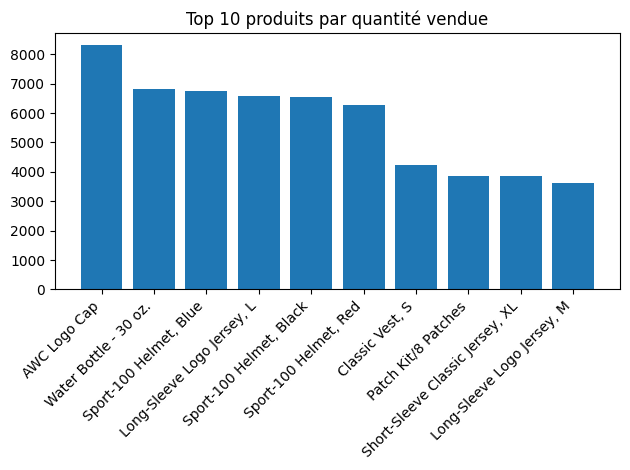

In [36]:
import matplotlib.pyplot as plt

if DB_NAME == "AdventureWorks2022":
    q = '''
    SELECT TOP 10 p.Name AS ProductName, SUM(sod.OrderQty) AS TotalQty
    FROM Sales.SalesOrderDetail sod
    JOIN Production.Product p ON sod.ProductID = p.ProductID
    GROUP BY p.Name
    ORDER BY TotalQty DESC;
    '''
    conn_or_engine = get_engine_or_conn(DB_NAME)
    top_products = pd.read_sql(q, conn_or_engine)
    display(top_products)

    plt.figure()
    plt.bar(top_products["ProductName"], top_products["TotalQty"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top 10 produits par quantité vendue")
    plt.tight_layout()
    plt.show()

## 🧰 Requête libre

In [37]:
def run_sql(query: str, database: str = None) -> pd.DataFrame:
    database = database or DB_NAME
    conn_or_engine = get_engine_or_conn(database)
    return pd.read_sql(query, conn_or_engine)

# Exemple:
run_sql("SELECT TOP 5 * FROM Person.Person")

✅ Connexion SQLAlchemy OK


,BusinessEntityID,PersonType,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,EmailPromotion,AdditionalContactInfo,Demographics,rowguid,ModifiedDate
0,1,EM,False,None,Ken,J,Sánchez,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",92C4279F-1207-48A3-8448-4636514EB7E2,2009-01-07
1,2,EM,False,None,Terri,Lee,Duffy,None,1,None,"<IndividualSurvey xmlns=""http://schemas.micros...",D8763459-8AA8-47CC-AFF7-C9079AF79033,2008-01-24
2,3,EM,False,None,Roberto,None,Tamburello,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",E1A2555E-0828-434B-A33B-6F38136A37DE,2007-11-04
3,4,EM,False,None,Rob,None,Walters,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F2D7CE06-38B3-4357-805B-F4B6B71C01FF,2007-11-28
4,5,EM,False,Ms.,Gail,A,Erickson,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F3A3F6B4-AE3B-430C-A754-9F2231BA6FEF,2007-12-30


In [44]:
query = """
SELECT TABLE_SCHEMA, TABLE_NAME
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE = 'BASE TABLE'
  AND TABLE_SCHEMA = 'Sales'
ORDER BY TABLE_NAME;
"""

tables = pd.read_sql(query, conn_or_engine)
print(tables.shape)
tables


(19, 2)


,TABLE_SCHEMA,TABLE_NAME
0,Sales,CountryRegionCurrency
1,Sales,CreditCard
2,Sales,Currency
3,Sales,CurrencyRate
4,Sales,Customer
5,Sales,PersonCreditCard
6,Sales,SalesOrderDetail
7,Sales,SalesOrderHeader
8,Sales,SalesOrderHeaderSalesReason
9,Sales,SalesPerson


In [54]:
run_sql("SELECT TOP 5 * FROM Sales.CountryRegionCurrency")
#run_sql("SELECT TOP 5 * FROM Sales.Store")
#run_sql("SELECT * FROM Sales.Store")   
#run_sql("SELECT TOP 5 * FROM Sales.SalesOrderHeader") 

✅ Connexion SQLAlchemy OK


,CountryRegionCode,CurrencyCode,ModifiedDate
0,AE,AED,2014-02-08 10:17:21.510
1,AR,ARS,2014-02-08 10:17:21.510
2,AT,ATS,2014-02-08 10:17:21.510
3,AT,EUR,2008-04-30 00:00:00.000
4,AU,AUD,2014-02-08 10:17:21.510


In [41]:
df_sales_details = run_sql("SELECT * FROM Sales.SalesOrderDetail") 
df_sales_details.shape

✅ Connexion SQLAlchemy OK


(121317, 11)

In [47]:
#df_sales_details.head(50)

In [49]:
df_sales_order_header = run_sql("SELECT * FROM Sales.SalesOrderHeader") 
df_sales_order_header.shape

✅ Connexion SQLAlchemy OK


(31465, 26)

In [53]:
df_sales_order_header.head(5)

,SalesOrderID,RevisionNumber,OrderDate,DueDate,ShipDate,Status,OnlineOrderFlag,SalesOrderNumber,PurchaseOrderNumber,AccountNumber,...,CreditCardID,CreditCardApprovalCode,CurrencyRateID,SubTotal,TaxAmt,Freight,TotalDue,Comment,rowguid,ModifiedDate
0,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,...,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07
1,43660,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43660,PO18850127500,10-4020-000117,...,5618.0,115213Vi29411,NaN,1294.2529,124.2483,38.8276,1457.3288,None,738DC42D-D03B-48A1-9822-F95A67EA7389,2011-06-07
2,43661,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43661,PO18473189620,10-4020-000442,...,1346.0,85274Vi6854,4.0,32726.4786,3153.7696,985.5530,36865.8012,None,D91B9131-18A4-4A11-BC3A-90B6F53E9D74,2011-06-07
3,43662,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43662,PO18444174044,10-4020-000227,...,10456.0,125295Vi53935,4.0,28832.5289,2775.1646,867.2389,32474.9324,None,4A1ECFC0-CC3A-4740-B028-1C50BB48711C,2011-06-07
4,43663,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43663,PO18009186470,10-4020-000510,...,4322.0,45303Vi22691,NaN,419.4589,40.2681,12.5838,472.3108,None,9B1E7A40-6AE0-4AD3-811C-A64951857C4B,2011-06-07
